In [1]:
import numpy as np


class Perceptron:
    """
    # 퍼셉트론 분류기
    
    1. 매개변수
    - eta : 학습률(0.0 ~ 1.0)
    - n_iter : 훈련 데이터셋 반복 횟수
    - random_state : 무작위 초기화 난수
    
    2. 속성
    - w_ : 학습된 가중치
    - b_ : 학습된 절편 유닛
    - errors_ : 에포크마다 누적된 분류 오류
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        # 훈련 데이터 학습
        
        1. 매개변수
        - X : n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        - y : 타깃 값
        
        2. 반환값
        - self 
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """단위 계단 함수 -> 클래스 레이블 반환"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [2]:
import os
import pandas as pd

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL : ', s)

URL :  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [3]:
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


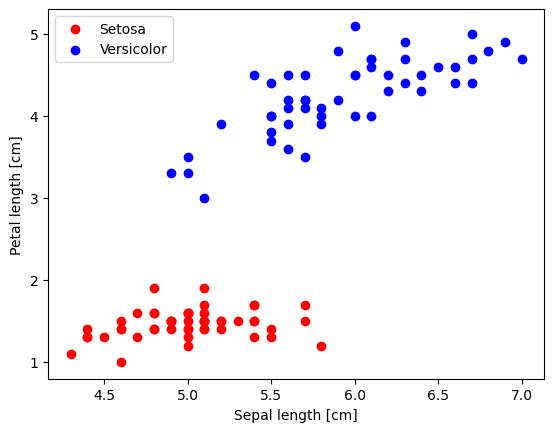

In [4]:
import matplotlib.pyplot as plt

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)
X = df.iloc[0:100, [0, 2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='o', label='Versicolor')
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

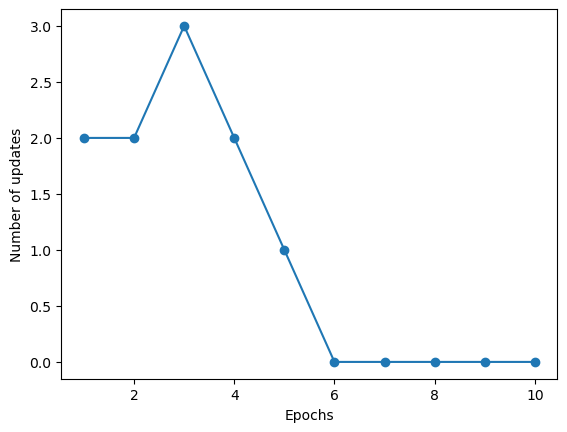

In [5]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [8]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):
    # 마커, 컬러맵 설정
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플 산점도
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

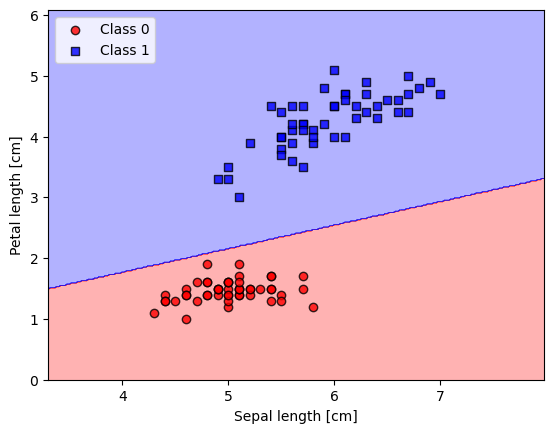

In [9]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [10]:
class AdalineGD:
    """
    # 적응형 선형 뉴런 분류기
    
    1. 매개변수
    - eta : 학습률(0.0 ~ 1.0)
    - n_iter : 훈련 데이터셋 반복 횟수
    - random_state : 무작위 초기화 난수
    
    2. 속성
    - w_ : 학습된 가중치
    - b_ : 학습된 절편 유닛
    - losses_ : 각 에포크 평균 제곱 오차 손실 함수 값
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """
        # 훈련 데이터 학습
        
        1. 매개변수
        - X : n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        - y : 타깃 값
        
        2. 반환값
        - self
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors ** 2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수 -> 클래스 레이블 반환"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

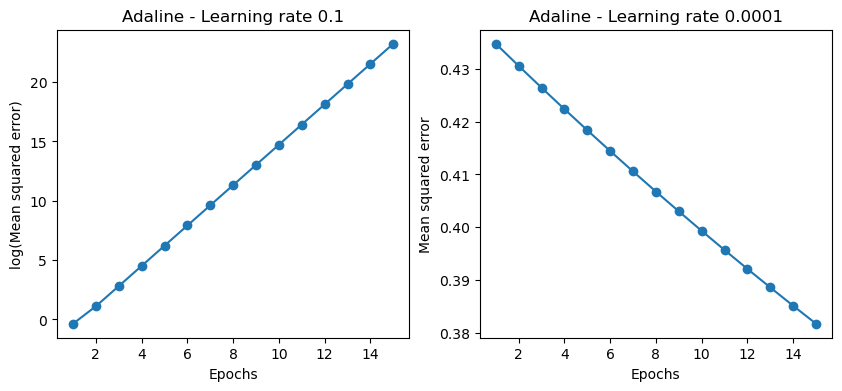

In [11]:
fit, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')
ada2 = AdalineGD(n_iter=15, eta=0.0001, random_state=1).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()

In [12]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

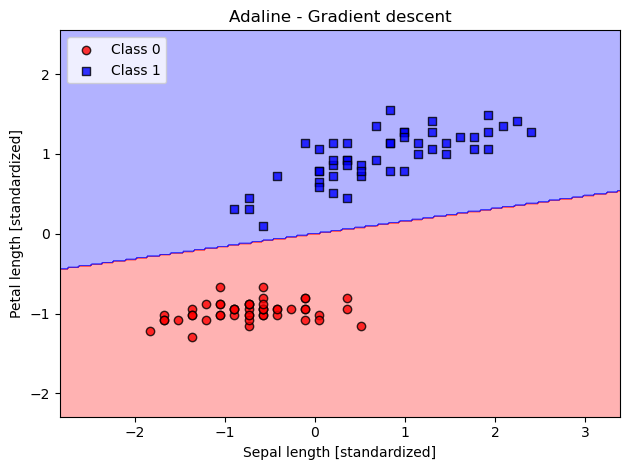

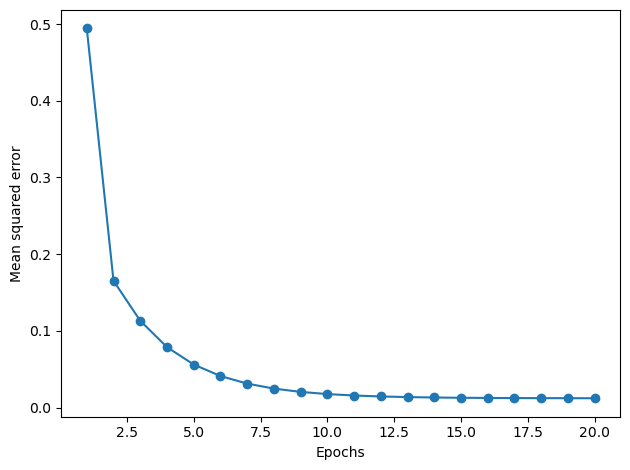

In [13]:
ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.show()

In [14]:
class AdalineSGD:
    """
    # ADALINE 분류기
    
    1. 매개변수
    - eta : 학습률(0.0 ~ 1.0)
    - n_iter : 훈련 데이터셋 반복 횟수
    - shuffle : True 설정 시 같은 반복이 되지 않도록 훈련 데이터 섞기
    - random_state : 무작위 초기화 난수
    
    2. 속성
    - w_ : 학습된 가중치
    - b_ : 학습된 절편 유닛
    - losses_ : 각 에포크 평균 제곱 오차 손실 함수 값
    """

    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """
        # 훈련 데이터 학습
        
        1. 매개변수
        - X : n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        - y : 타깃 값
        
        2. 반환값
        - self
        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """가중치 초기화하지 않고 훈련 데이터 학습"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터 섞기"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """랜덤 수로 가중치 초기화"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """아달린 학습 규칙 -> 가중치 업데이트"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error ** 2
        return loss

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수 -> 클래스 레이블 반환"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

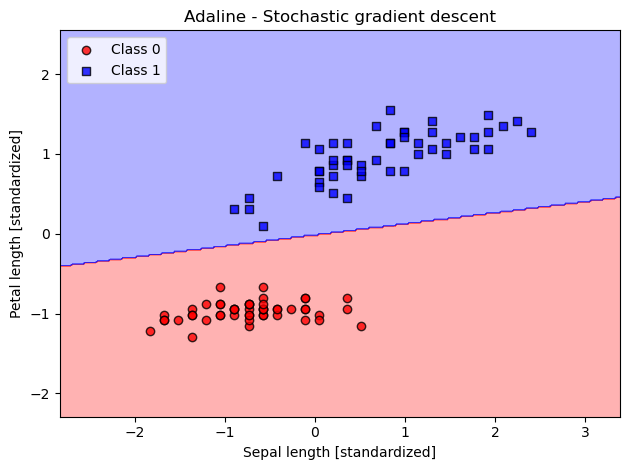

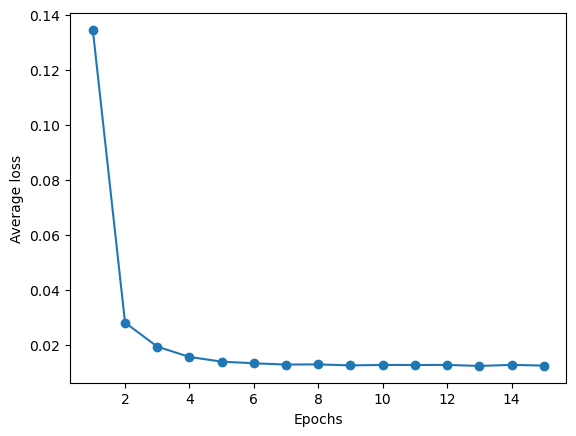

In [15]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.show()